###### import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter, OrderedDict
from nltk.corpus import stopwords
import re

from automation_mapping import *
from automating_tech_helpers import *
from machines_helpers import *
from ai_tech_helpers import *

%matplotlib inline

# Load Data

In [1156]:
tt15copy = tt15.copy()
t15copy = t15.copy()

In [3]:
## load data
unspsc = pd.read_table('../data/onet_tools_technology/UNSPSC Reference.txt') # occupation code database
tt6 = pd.read_csv('../data/db06/Tools_and_Technology.csv') # tools & tech 2006
tt9 = pd.read_csv('../data/db09/Tools and Technology.csv') # tools & tech 2009
tt15 = pd.read_table('../data/db15/Tools and Technology.txt') # tools & tech 2015
occ_ref = pd.read_csv('../data/db15/helpers/occ_codes/occupation_reference.csv')

## add occupation titles to tt15
# tt15 = tt15.merge(occ_ref, how = 'left', on = ['O*NET-SOC Code'])
# tt15.columns = list(tt15.columns[:-1]) + ["O*NET-SOC Title"]

# Clean Data

In [1510]:
### add automation, ai, machinery classes to each df
### that is, check if the type of the technology is either:
###      a) general automation technology
###      b) high-technology ai technology
###      c) machinery-related
def add_automation_variables(df):
    new_df = df.copy()
    new_df = add_group_automation(new_df, automating_tech, group = 'Class', outcome_title = 'automating')
    new_df = add_group_automation(new_df, ai_tech, group = 'Class', outcome_title = 'ai')
    new_df = add_group_automation(new_df, machines, group = 'Segment', outcome_title = 'machinery')
    new_df['software'] = new_df['Commodity Title'].apply(lambda x: 'software' in x.lower())
    return new_df

# tt6 = add_automation_variables(tt6)
# tt9 = add_automation_variables(tt9)
# tt15 = add_automation_variables(tt15)

## add the missing grouping: family
tt15['Segment Code'] = create_codes(tt15, group = 'Segment')
tt15['Class Code'] = create_codes(tt15, group = 'Class')
tt15['Family Code'] = create_codes(tt15, group = 'Family')
tt15.columns = ['O*NET-SOC Code',
 'T2 Type',
 'T2 Example',
 'Commodity Code',
 'Commodity Title',
 'O*NET-SOC Title',
 'Segment Code',
 'Class Code',
 'Family Code']

In [1511]:
# for ease of use, format df's to have the same column order
# columns = ['O*NET-SOC Code',
#            'O*NET-SOC Title',
#            'T2 Type',
#            'T2 Example',
#            'Commodity Code',
#            'Commodity Title',
#            'Class Code',
#            'Segment Code',
#            'automating',
#            'ai',
#            'machinery'
#           ]

# tt6 = tt6.reindex_axis(columns, axis = 1)
# tt9 = tt9.reindex_axis(columns, axis = 1)
# tt15 = tt15.reindex_axis(columns, axis = 1)

In [1512]:
# removing stopwords and punctuation for ease of use
def remove_punc_stopwords_lower(s):
    stop = stopwords.words('english')
    regex = r"\W+"
    return " ".join([i for i in re.split(regex, s.lower()) if i not in stop])

tt6['Commodity Title'] = tt6['Commodity Title'].apply(lambda x: remove_punc_stopwords_lower(x))
tt9['Commodity Title'] = tt9['Commodity Title'].apply(lambda x: remove_punc_stopwords_lower(x))
tt15['Commodity Title'] = tt15['Commodity Title'].apply(lambda x: remove_punc_stopwords_lower(x))

In [1513]:
# add occupation major, minor, and broad groups. Major > minor > broad in "generalization"

major_groups = pd.read_csv('../data/db15/helpers/occ_codes/major_groups.csv')
minor_groups = pd.read_csv('../data/db15/helpers/occ_codes/minor_groups.csv')
broad_groups = pd.read_csv('../data/db15/helpers/occ_codes/broad_groups.csv')
detailed_occupations = pd.read_csv('../data/db15/helpers/occ_codes/detailed_occupations.csv')

def get_groupings(df, group):
    zeroes = 3
    if group == "broad":
        add = 1
    elif group == "minor":
        add = 3
    elif group == "major":
        add = 4
    column = df['O*NET-SOC Code'].apply(lambda x: x[:-(zeroes + add)] + add*'0')
    return column

for group in ['broad', 'minor', 'major']:
    tt15[group+"_group"] = get_groupings(tt15, group)

# Create Occupational Reference

In [1514]:
for group in ['broad', 'minor', 'major']:
    occ_ref[group+"_group"] = get_groupings(occ_ref, group)

In [1515]:
for group in ['broad', 'minor', 'major']:
    occ_ref[group+"_group"] = get_groupings(occ_ref, group)

def add_group_titles(df):
    add_broad = df.merge(broad_groups, on = 'broad_group')
    add_minor = add_broad.merge(minor_groups, on = 'minor_group')
    add_major = add_minor.merge(major_groups, on='major_group')
    return add_major

occ_ref = add_group_titles(occ_ref)

# Merge Occupation Data

In [1523]:
merged = tt15.merge(occ_ref, on = "O*NET-SOC Code")
print len(merged['O*NET-SOC Code'].unique()), merged.shape, tt15.shape

945 (61563, 19) (65455, 12)


In [1505]:
just_titles = occ_ref[['O*NET-SOC Code', 'broad_title', 'minor_title', 'major_title']]
tt15 = tt15.merge(just_titles, on = 'O*NET-SOC Code')

# Find occupations that adopted technology

In [604]:
def get_innovative_occupations(df_old, df_new, outcome_class, code = False):
    subset = df_new[df_new[outcome_class] == True]
    occupation_dict = {}
    if code:
        match = 'O*NET-SOC Code'
        col = 'Commodity Code'
    else:
        match = 'O*NET-SOC Title'
        col = 'Commodity Title'
    for occupation in df_new[match].unique():
        new_tech = df_new[df_new[match] == occupation][col].unique()
        old_tech = df_old[df_old[match] == occupation][col].unique()
        adopted_tech = [i for i in new_tech if i not in old_tech]
        occupation_dict[occupation] = (len(adopted_tech), adopted_tech)
    return occupation_dict

def get_software_adopters(df_old, df_new):
    pass

In [231]:
innovative_occupations = get_innovative_occupations(tt9, tt15, 'ai')

# Occupations that relinquished technology

In [232]:
dropping_occupations = get_innovative_occupations(tt15, tt9, 'ai')

In [234]:
tt15[tt15['O*NET-SOC Title'].apply(lambda x: 'computer' in x.lower()) == True]['O*NET-SOC Title'].unique()

array(['Computer and Information Systems Managers',
       'Computer Hardware Engineers',
       'Electronics Engineers, Except Computer', 'Computer Operators',
       'Computer, Automated Teller, and Office Machine Repairers',
       'Computer-Controlled Machine Tool Operators, Metal and Plastic'], dtype=object)

# common technologies

In [1316]:
def get_popular_terms(series, n_most_common, n_words = None):
    tech_list = []
    if type(n_words) == int:
        for tech in series:
            tech_list += [" ".join(g) for g in nltk.ngrams(tech.split(), n_words)]
        return Counter(tech_list).most_common(n_most_common)
    else:
        return Counter(list(series)).most_common(n_most_common)

In [1228]:
get_popular_terms(tt15['T2 Example'], 20, 3)

[('Adobe Systems Adobe', 627),
 ('Microsoft Office software', 506),
 ('Web browser software', 423),
 ('Data entry software', 200),
 ('Laser facsimile machines', 169),
 ('Multi-line telephone systems', 151),
 ('Word processing software', 143),
 ('Computer laser printers', 128),
 ('Personal digital assistants', 115),
 ('digital assistants PDA', 114),
 ('Autodesk AutoCAD software', 111),
 ('Systems Adobe Photoshop', 107),
 ('Liquid crystal display', 104),
 ('crystal display LCD', 104),
 ('Adobe Photoshop software', 104),
 ('positioning system GPS', 103),
 ('data input scanners', 103),
 ('Computer data input', 102),
 ('Microsoft Visual Basic', 99),
 ('Systems Adobe Acrobat', 96)]

## Adoptions by adopting companies

In [1297]:
def get_adopting_companies(now, old):
    columns = ['O*NET-SOC Code', 'O*NET-SOC Title', 'Commodity Code', 'Commodity Title', 'T2 Example']
    def just_tech_title(df):
        return df[columns]
    tech_now = just_tech_title(now)
    tech_old = just_tech_title(old)
    master_df = pd.DataFrame(columns = now.columns)
    for occ in tech_now['O*NET-SOC Code'].unique():
        new_group_tech = set(tech_now[tech_now['O*NET-SOC Code'] == occ]['Commodity Code'].unique())
        old_group_tech = set(tech_old[tech_old['O*NET-SOC Code'] == occ]['Commodity Code'].unique())
        adopted_tech = list(new_group_tech - old_group_tech)
        adopted_tech_df = tech_now[(tech_now['Commodity Code'].isin(adopted_tech)) & (tech_now['O*NET-SOC Code'] == occ)]
        master_df = master_df.append(adopted_tech_df)
    return master_df

In [1298]:
all_adoptions = get_adopting_companies(tt15, tt9)

# "Bright outlook" occupations

In [1306]:
bright_outlook = pd.read_csv('../data/db15/helpers/bright_outlooks/All_Bright_Outlook_Occupations.csv')

In [1326]:
bo_tools = tt15[tt15['O*NET-SOC Code'].isin(bright_outlook.Code)]
bo_tools['Commodity Title'] = bo_tools['Commodity Title'].apply(lambda x: remove_punc_stopwords_lower(x))

/Users/Logan/anaconda/envs/dev/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


In [1327]:
get_popular_terms(bo_tools['Commodity Title'], 20)

[('analytical scientific software', 1092),
 ('medical software', 1006),
 ('data base user interface query software', 878),
 ('development environment software', 440),
 ('word processing software', 364),
 ('spreadsheet software', 359),
 ('enterprise resource planning erp software', 349),
 ('project management software', 322),
 ('computer aided design cad software', 321),
 ('financial analysis software', 316),
 ('electronic mail software', 307),
 ('object component oriented development software', 306),
 ('personal computers', 281),
 ('accounting software', 275),
 ('desktop computers', 248),
 ('notebook computers', 247),
 ('internet browser software', 234),
 ('operating system software', 232),
 ('web platform development software', 230),
 ('office suite software', 217)]

# \# of Occupations that only picked up technology

In [1328]:
tt15occs = tt15['O*NET-SOC Code'].unique()
l9 = tt9[tt9['O*NET-SOC Code'].isin(tt15occs)]

In [1333]:
occdict = {}
for occ in tt15occs:
    old_tech = list(tt9[tt9['O*NET-SOC Code'] == occ]['Commodity Code'])
    new_tech = list(tt15[tt15['O*NET-SOC Code'] == occ]['Commodity Code'])
    if all([i in new_tech for i in old_tech]):
        exclusive_tech = [i for i in new_tech if i not in old_tech]
        if exclusive_tech:
            occdict[occ] = exclusive_tech

In [1334]:
float(len(occdict)) / len(tt15occs) * 100

51.129363449691986

**~51% of occupations just picked up new technologies.** What is the breakdown of new technologies adopted? Which occupations adopted them?

# Fully featured dataset

In [426]:
skills = pd.read_table('../data/db15/Skills.txt')
abilities = pd.read_table('../data/db15/Abilities.txt')
knowledge = pd.read_table('../data/db15/Knowledge.txt')
activities = pd.read_table('../data/db15/Work Activities.txt')

In [12]:
def get_reduced_df(df):
    new_df = df[df['Scale ID'] == 'LV'][['O*NET-SOC Code', 'Element Name', 'Data Value']].reset_index(drop = True)
    return new_df.pivot(index = 'O*NET-SOC Code', columns = 'Element Name', values = 'Data Value').reset_index(level = 1)

In [737]:
skills_X = get_reduced_df(skills)
abilities_X = get_reduced_df(abilities)
knowledge_X = get_reduced_df(knowledge)
activities_X = get_reduced_df(activities)

In [738]:
for X in [skills_X, abilities_X, knowledge_X, activities_X]:
    t15 = t15.merge(X, on="O*NET-SOC Code")

In [741]:
t15.columns

Index([u'O*NET-SOC Code', u'O*NET-SOC Title', u'T2 Type', u'T2 Example',
       u'Commodity Code', u'Commodity Title', u'Class Code', u'Segment Code',
       u'automating', u'ai', 
       ...
       u'Provide Consultation and Advice to Others',
       u'Repairing and Maintaining Electronic Equipment',
       u'Repairing and Maintaining Mechanical Equipment',
       u'Resolving Conflicts and Negotiating with Others',
       u'Scheduling Work and Activities', u'Selling or Influencing Others',
       u'Staffing Organizational Units', u'Thinking Creatively',
       u'Training and Teaching Others',
       u'Updating and Using Relevant Knowledge'],
      dtype='object', length=176)

# Technology outcome class

In [704]:
t15['it'] = t15['Segment Code'].apply(lambda x: x == 43000000)

In [711]:
S = t15.groupby('O*NET-SOC Code')['it'].sum()

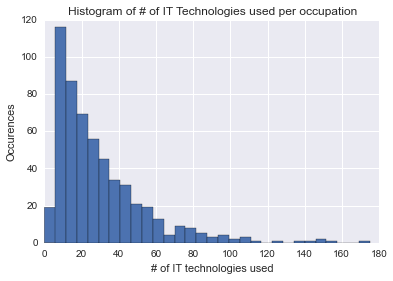

In [731]:
sns.plt.hist(S, bins = 30)
sns.plt.title('Histogram of # of IT Technologies used per occupation')
sns.plt.xlabel('# of IT technologies used')
sns.plt.ylabel('Occurences')
sns.plt.savefig('it_histogram.png')

In [719]:
occ_names[occ_names['O*NET-SOC Code'].isin(['51-3093.00', '35-9021.00'])]

,O*NET-SOC Code,O*NET-SOC Title
392,35-9021.00,Dishwashers
558,51-3093.00,Food Cooking Machine Operators and Tenders


# What types of technology emerged?

In [1343]:
s15 = set(tt15['Commodity Code'].unique())
s9 = set(tt9['Commodity Code'].unique())
s6 = set(tt9['Commodity Code'].unique())
new_tech = list(s15 - s6)

def get_tech_info(commodity_code, d):
    title = d[d['Commodity Code'] == commodity_code]['Commodity Title'].iloc[0]
    
    class_code = int(str(commodity_code)[:-2] + 2*'0')
    class_title = d[d['Class Code'] == class_code]['Class Title'].iloc[0]

    family_code = int(str(commodity_code)[:-4] + 4*'0')
    family_title = d[d['Family Code'] == family_code]['Family Title'].iloc[0]
    
    segment_code = int(str(commodity_code)[:-6] + 6*'0')
    segment_title = d[d['Segment Code'] == segment_code]['Segment Title'].iloc[0]
    
    return [commodity_code, title, class_title, family_title, segment_title]

col_titles = ['Code','Technology', 'Class', 'Family', 'Segment']
new_tech_info = pd.DataFrame(map(lambda x: get_tech_info(x, unspsc), new_tech), columns = col_titles)
emerged = new_tech_info.Code

In [1372]:
print float(len(new_tech)) / (len(tt15['Commodity Code'].unique())) * 100, '% of 2015 tech is emerging tech'

33.0151338766 % of 2015 tech is emerging tech


In [1365]:
print np.mean(tt15['Commodity Code'].isin(new_tech)) * 100, "% of tech adoptions were of emerged technologies"

8.54480177221 % of tech adoptions were of emerged technologies


In [1368]:
col_titles = ['Code','Technology', 'Class', 'Family', 'Segment']
adoptions = pd.DataFrame(map(lambda x: get_tech_info(x, unspsc), list(adopted_emerging['Commodity Code'])), columns = col_titles)

In [1375]:
new_tech_info.Class.value_counts()

Domestic kitchen tools and utensils                                    26
Cutting and crimping and punching tools                                22
Rough and finishing tools                                              20
Holding and clamping tools                                             19
Power tools                                                            17
Vehicle servicing equipment                                            17
Tool attachments and accessories                                       16
Length and thickness and distance measuring instruments                16
Welding machinery                                                      16
Wrenches and drivers                                                   15
Miscellaneous sewing supplies                                          14
Audio and visual equipment                                             14
Textile processing machinery and accessories                           14
Welding and soldering and brazing acce

# What Types of Occupations Adopted Emerging Tech

In [1489]:
adopting_occs = tt15[tt15['Commodity Code'].isin(emerged)]['O*NET-SOC Code'].unique()
total_occs = tt15['O*NET-SOC Code'].unique()

In [1490]:
float(len(adopting_occs))/len(total_occs)

0.7396825396825397

In [1382]:
def get_occupation_info(code, d):
    if code[-3] == '.':
        code = code[:-3]
    df = d[d['code'] == code]
    info = []
    for attribute in ['title', 'broad_title', 'minor_title', 'major_title']:
        info.append(df[attribute].iloc[0])
    return info

In [1531]:
# 1. Merge tt15, group titles
# 2. Check adoption by groups

In [1536]:
len(tt15.merge(broad_groups, how = 'left', on = 'broad_group').merge(minor_groups, how = 'left', on = 'minor_group').merge(major_groups, how = 'left', on = 'major_group')['O*NET-SOC Code'].unique())

974

# Did anything change?

In [83]:
import pandas as pd
import numpy as np

In [84]:
def get_reduced_df(df):
    new_df = df[df['Scale ID'] == 'LV'][['O*NET-SOC Code', 'Element Name', 'Data Value']].reset_index(drop = True)
    return new_df.pivot(index = 'O*NET-SOC Code', columns = 'Element Name', values = 'Data Value').reset_index(level = 1)

In [85]:
d2014 = get_reduced_df(pd.read_table('/Users/Logan/Downloads/db_19_0/Skills.txt'))
d2013 = get_reduced_df(pd.read_table('/Users/Logan/Downloads/db_18_0/Skills.txt'))
d2012 = get_reduced_df(pd.read_table('/Users/Logan/Downloads/db_17_0/Skills.txt'))
d2011 = get_reduced_df(pd.read_table('/Users/Logan/Downloads/db_16_0/Skills.txt'))

In [86]:
d2014.shape, d2013.shape, d2012.shape, d2011.shape

((942, 36), (923, 36), (903, 36), (862, 36))

In [87]:
for df in 'd2014 d2013 d2012'.split():
    d2014[d2014['O*NET-SOC Code'].isin(d2011['O*NET-SOC Code'])]
    append = "['O*NET-SOC Code'].isin(d2011['O*NET-SOC Code'])]"
    beginning = df + '[' + df
    assign = df + ' = '
    exec(assign + beginning + append)

# between 2009 and 2015, what % of entries changed?

In [98]:
d2009 = get_reduced_df(pd.read_table('../data/db09/Skills.txt'))
d2015 = get_reduced_df(pd.read_table('../data/db15/Skills.txt'))

d2015 = d2015[d2015['O*NET-SOC Code'].isin(d2009['O*NET-SOC Code'])]
d2009 = d2009[d2009['O*NET-SOC Code'].isin(d2015['O*NET-SOC Code'])]

In [110]:
st = np.subtract(d2015.iloc[:,1:], d2009.iloc[:,1:])
(st == 0).mean()

Element Name
Active Learning                      0.051383
Active Listening                     0.042161
Complex Problem Solving              0.052701
Coordination                         0.051383
Critical Thinking                    0.047431
Equipment Maintenance                0.061924
Equipment Selection                  0.047431
Installation                         0.073781
Instructing                          0.050066
Judgment and Decision Making         0.055336
Learning Strategies                  0.056653
Management of Financial Resources    0.046113
Management of Material Resources     0.047431
Management of Personnel Resources    0.057971
Mathematics                          0.051383
Monitoring                           0.060606
Negotiation                          0.054018
Operation Monitoring                 0.044796
Operation and Control                0.052701
Operations Analysis                  0.006588
Persuasion                           0.052701
Programming          